# AI for Network Optimization

数据加载和预处理（生成关键参数，重要！！！）



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io as sio

from google.colab import drive
from matplotlib.colors import TwoSlopeNorm


## 加载数据和预处理函数

In [ ]:
# Load and Pre-process Data


def load_mat_data(filename):
    mat_data = sio.loadmat(filename, squeeze_me=True, struct_as_record=False)
    DataSet = mat_data['DataSet']
    return DataSet


def func_gen_params(Sample):
    """
    func_gen_params - Python 等价版本（兼容从 MATLAB 加载的 struct）

    输入:
        Sample : 从 scipy.io.loadmat() 得到的结构体，对象访问形式:
                 Sample.params.beta
                 Sample.cell_para.cell_pos
                 Sample.user_para.user_pos

    输出:
        M, N        : 小区数与用户数
        Dist        : 距离矩阵 (M × N)
        Rsrp        : 信号强度矩阵 (M × N)
        Capa        : 信道容量矩阵 (M × N)
        Prob        : 用户连接概率矩阵 (M × N)
        Conn        : 用户连接指示矩阵 (M × N)
        NeighCell   : 邻区矩阵 (M × M)
    """

    # ========== 参数读取 ==========
    beta = Sample.params.beta
    cell_pos = Sample.cell_para.cell_pos
    user_pos = Sample.user_para.user_pos

    cell_pos = np.array(cell_pos, dtype=float)
    user_pos = np.array(user_pos, dtype=float)

    # ========== 基本尺寸 ==========
    M, _ = cell_pos.shape
    N, _ = user_pos.shape

    # 3. 距离矩阵 Dist[M, N]
    MinDist = 100
    Dist = np.linalg.norm(cell_pos[:, None, :] - user_pos[None, :, :], axis=2)
    Dist [Dist < MinDist] = MinDist

    # 4. RSRP矩阵 Rsrp[M, N]:  -65dBm ~ -125dBm (对应50米-2000米)
    #     -65 dBm (50米)
    #     -76.3 dBm (100米)
    #     -87.6 dBm (200米)
    #     -98.9 dBm (400米)
    #     -105.6 dBm (600米)
    #     -110.3 dBm (800米)
    #     -113.9 dBm (1000米)
    #     -120.5 dBm (1500米)
    #     -125.2 dBm (2000米)
    G0 = -65        # 包含发射功率、天线增益、频率衰减系数等所有其他因素（距离除外）
    Loss_factor = 3.76   # 城市环境距离衰减因子
    Rsrp = G0 - 10 * Loss_factor * np.log10(Dist/50)

    # 5. 信道容量矩阵 Capa[M, N]：
    #     11.6 bit/s/Hz (50米)  --> 116 Mbit/s
    #     7.87 bit/s/Hz (100米) --> 78.7 Mbit/s  （10M带宽）
    #     4.19 bit/s/Hz (200米) --> 41.9 Mbit/s
    #     1.18 bit/s/Hz (400米) --> 11.8 Mbit/s
    #     0.35 bit/s/Hz (600米) --> 7.0 Mbit/s
    #     0.13 bit/s/Hz (800米) --> 1.3 Mbit/s
    #     0.057 bit/s/Hz (1000米) --> 0.57 Mbit/s
    #     0.013 bit/s/Hz (1500米) --> 0.13 Mbit/s
    #     0.0043 bit/s/Hz (2000米) --> 0.043 Mbit/s
    I_Noise = -100   # 干扰+噪声功率：-100 dB
    SINR = Rsrp - I_Noise
    Capa = np.log2(1 + 10**(SINR/10))

    # 6. 初始关联矩阵 Conn[M, N]
    MaxDist = 500          # 接入阈值，超过此距离Conn=0
    Conn = (Dist <= MaxDist).astype(int)

    # 7. 初始接入概率 或 流量分配矩阵 Alloc[M, N]:
    #   根据softmax进行分配：alloc_prob = exp(rsrp*beta) / sum( exp(rsrp * beta))
    CIO = np.zeros(M)

    rsrp_cio = Rsrp + CIO[:, np.newaxis]

    rsrp_normalized = rsrp_cio - rsrp_cio.max(axis=0) # 归一化，便于softmax计算

    beta = 0.2   # 流量分配权重系数: beta越大，分配越集中/不均匀（重要！！！）

    exp_rsrp = np.exp(rsrp_normalized * beta) * Conn
    sum_exp = exp_rsrp.sum(axis=0, keepdims=True)
    sum_exp[sum_exp==0] = 1e-9
    Prob = exp_rsrp / sum_exp  # allocation probability

    # 8. 更新关联矩阵 和 接入概率（流量分配）
    #   降低仿真复杂度：移除概率小于 prob_th 的关联链路，重新计算概率

    prob_th = 0.05  # 最小接入概率阈值：prob_th 越大，分配越集中（重要！！！）

    Conn [Prob<prob_th] = 0
    exp_rsrp = np.exp(rsrp_normalized * beta) * Conn
    sum_exp = exp_rsrp.sum(axis=0, keepdims=True)
    sum_exp[sum_exp==0] = 1e-9
    Prob = exp_rsrp / sum_exp


    # 提取每个小区的关联用户，用于加速计算（实测无法加速，重要！！！）
    ConnUser = [np.where(row == 1)[0].tolist() for row in Conn]


    # (new) 9. 计算每个小区的邻接小区，加速计算（重要！！！）
    NeighCell = np.zeros((M, M))

    for m in range(M):
        # step 1: 抽取第 m 行
        tmp_conn_m = Conn[m, :]     # shape (N,)
        # step 2: 计算 b = Conn @ a_m.T
        tmp_b = Conn @ tmp_conn_m       # shape (M,)
        # step 3: 二值化 b -> c
        tmp_c = (tmp_b > 0).astype(int)    # shape (M,)
        tmp_c[m] = 1  # 每个小区跟自己永远都是邻接小区
        # step 4: 将 c 赋给 NeighCell 的第 m 行和第 m 列
        NeighCell[m, :] = tmp_c
        NeighCell[:, m] = tmp_c



    # (new) 10. 计算每个小区load对每个xk的梯度值：grad_load_to_x
    GradLoad2X = np.zeros((M,M))  # (m,k): grad of load_m to x_k

    ALL_Cells_Bw = Sample.cell_para.ALL_Cells_Bw
    ALL_Users_Traffic = Sample.user_para.ALL_Users_Traffic


    for k in range(M):

        # gradient lk to xk (itself)
        tmp_lk_to_xk = beta * Conn[k,:] * Prob[k,:] * (1-Prob[k,:]) * ALL_Users_Traffic[:] / ALL_Cells_Bw[k] / (Capa[k,:] + 1e-9)
        GradLoad2X[k,k] = np.sum(tmp_lk_to_xk)

        # gradient lm to xk
        neighbor_cell = np.where(NeighCell[k, :] > 0)[0]
        for m in neighbor_cell:
            if m != k:
                tmp_lm_to_xk = - beta * Conn[m,:] * Prob[m,:] * Prob[k,:] * ALL_Users_Traffic[:] / ALL_Cells_Bw[m] / (Capa[m,:] + 1e-9)
                GradLoad2X[m,k] = np.sum(tmp_lm_to_xk)

    return M, N, Dist, Rsrp, Capa, Prob, Conn, NeighCell, GradLoad2X





## 关键函数

In [ ]:
# 关键变量和函数

# x_t: 决策变量，CIO
# beta: 概率分配因子，softmax参数
# Q0, Alpha, L0: QoS Degradation函数参数
# C0_all：Energy Cost函数参数，每个小区的能耗成本系数，np.random.uniform(1, 1, M)
# Wq, We：目标函数中QoS和Energy的权重
# Rsrp, Conn, Capa：预定义的RSRP矩阵，关联矩阵，容量矩阵
# ALL_Users_Traffic：向量A，每个用户的到达流量均值，np.random.uniform(xx, yy, N)
# ALL_Cells_Bw：向量B，每个小区的总带宽，np.ones(M) * 10


# 目标函数 Part I: QoS下降评估函数：QoS下降系数 * 总资源使用量
def func_Q(Load_m, ALL_Cells_Bw, Q0=0.5, L0=0.8, Alpha=20):
    return Q0 * np.exp(Alpha * (Load_m - L0)) * Load_m * ALL_Cells_Bw

# QoS下降函数针对load的梯度
def grad_Q_to_l(Load_m, ALL_Cells_Bw, Q0=0.5, L0=0.8, Alpha=20):
    QoS_Degrade = func_Q(Load_m, ALL_Cells_Bw, Q0, L0, Alpha)
    return (Alpha + 1/(Load_m + 1e-9)) * QoS_Degrade


# 目标函数 Part II: Energy成本函数：不同能源类型对应不同函数形式
def func_E(Load_m, ALL_Cells_Bw, C0_all):
    # 光伏+电网+电池，对应准Quadratic Function
    return C0_all * Load_m * ALL_Cells_Bw * Load_m * ALL_Cells_Bw

# Energy成本函数针对load的梯度
def grad_E_to_l(Load_m, ALL_Cells_Bw, C0_all):
    # 光伏+电网+电池，对应准Quadratic Function
    return 2 * C0_all * Load_m * ALL_Cells_Bw * ALL_Cells_Bw


# 流量分配概率矩阵（Softmax）
def scheduling_prob(x_t, Rsrp, Conn, beta):

    rsrp_cio = Rsrp + x_t[:, np.newaxis]
    rsrp_normalized = rsrp_cio - rsrp_cio.max(axis=0) # 归一化，便于softmax计算
    exp_rsrp = np.exp(rsrp_normalized * beta) * Conn
    # sum_exp = exp_rsrp.sum(axis=0, keepdims=True) + 1e-9  # 小概率列直接加1e-9会引入严重误差，只在零概率列（没有用户接入）加1e-9（重要！！！）
    sum_exp = exp_rsrp.sum(axis=0, keepdims=True)
    sum_exp[sum_exp==0] = 1e-9

    return exp_rsrp / sum_exp  # allocation probability [M, N]


# 预测系统总能力
def network_capa_estimate(Prob, Capa, Conn, ALL_Cells_Bw):
    cell_rows, user_cols = Prob.shape
    return np.mean(np.sum(Prob * Capa * Conn * ALL_Cells_Bw[:, np.newaxis], axis=0)) * cell_rows / user_cols



## 开始加载数据


In [ ]:
# Load和预处理数据：生成关键参数矩阵

# 1️⃣ 授权并挂载 Google Drive
drive.mount('/content/drive')

# 3️⃣ 读取文件 (示例：train_dataset_5000.mat)
data_path = '/content/drive/MyDrive/ColabData/Project2_dataset/(lenovo(11))2025122317_train_dataset_1000-v7.mat'

DataSet = load_mat_data(data_path)

print("✅ 文件成功加载！")


# read data sample

Sample = DataSet[12]

random_seed = Sample.params.rand_seed
cell_pos = Sample.cell_para.cell_pos
user_pos = Sample.user_para.user_pos

M, N, Dist, Rsrp, Capa, Prob, Conn, NeighCell, GradLoad2X = func_gen_params(Sample)




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ 文件成功加载！


## 展示数据


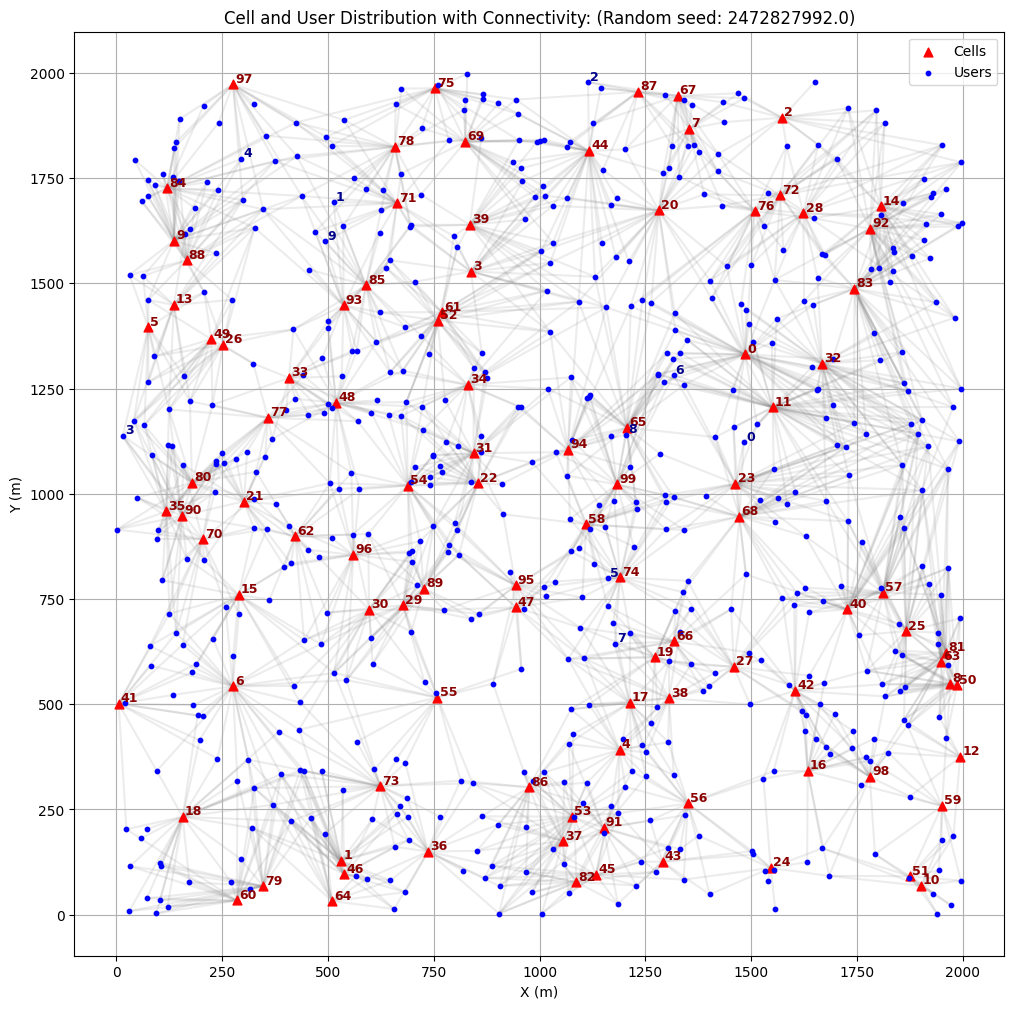

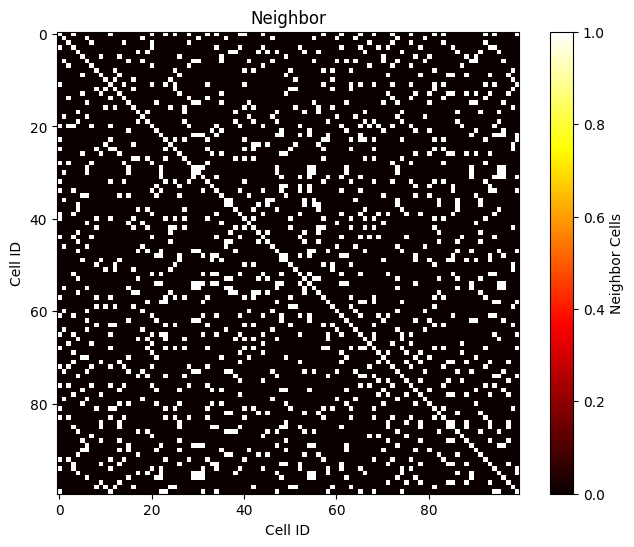

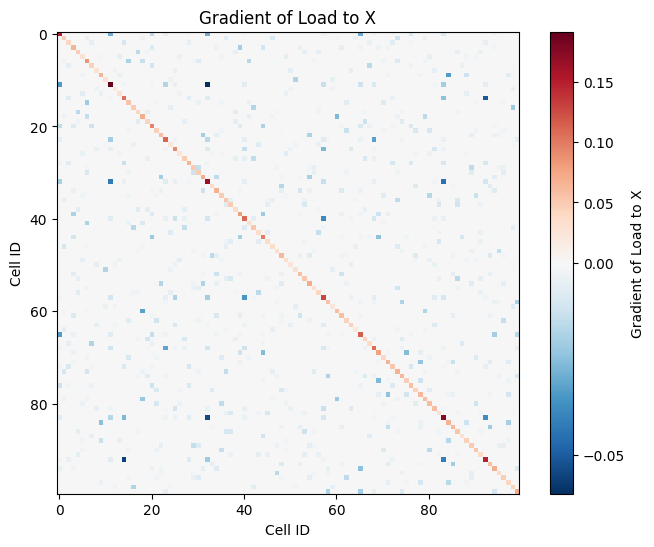

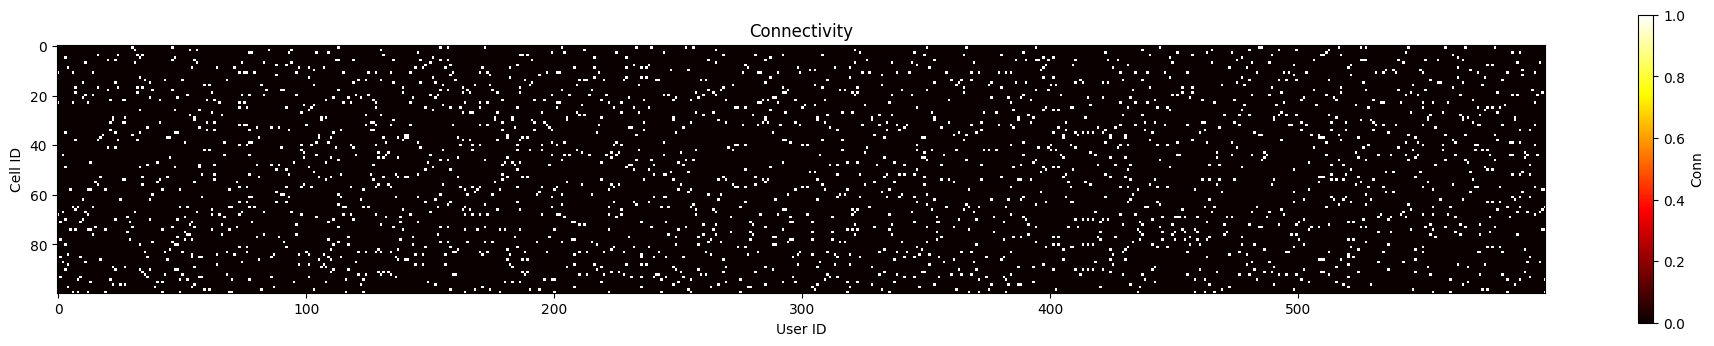

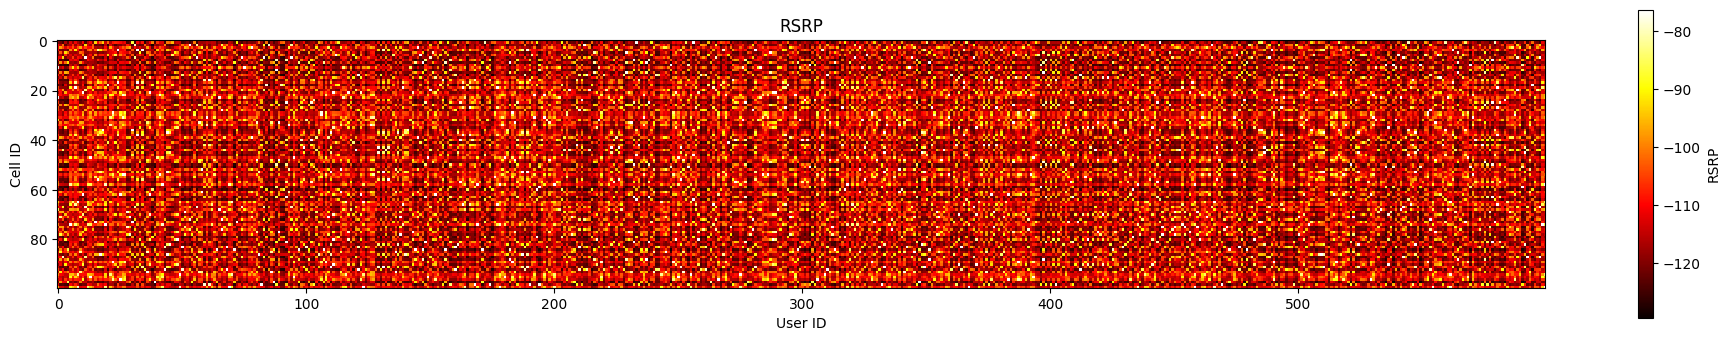

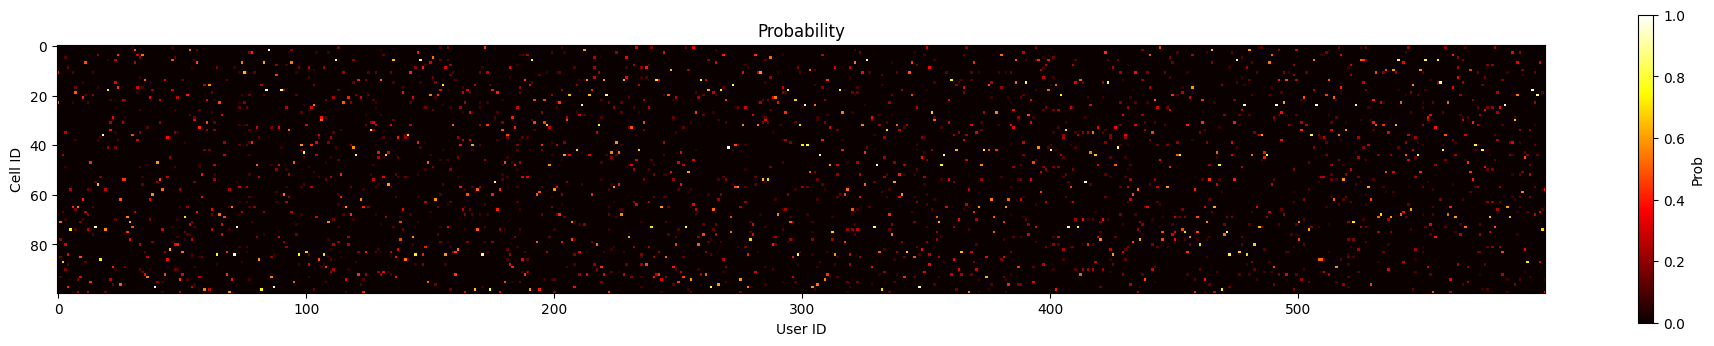

In [ ]:
# 直观展示场景图


# --- (1) 小区与用户空间分布及连接关系 ---
plt.figure(figsize=(12, 12))
# 绘制连接线
for m in range(M):
    connected_users = np.where(Conn[m, :] == 1)[0]
    for n in connected_users:
        plt.plot([cell_pos[m, 0], user_pos[n, 0]],
                 [cell_pos[m, 1], user_pos[n, 1]],
                 color='gray', alpha=0.15, zorder=1)

plt.scatter(cell_pos[:, 0], cell_pos[:, 1], c='red', marker='^', s=40, label='Cells', zorder=2)
plt.scatter(user_pos[:, 0], user_pos[:, 1], c='blue', s=10, label='Users', zorder=2)

# 在小区旁边标注编号
for m in range(M):
    plt.text(cell_pos[m, 0] + 5,       # 向右偏移一点避免遮挡
             cell_pos[m, 1] + 5,       # 向上偏移一点
             f"{m}", color='darkred', fontsize=9, weight='bold')

# 在用户0-10旁边标注编号
for n in range(10):
    plt.text(user_pos[n, 0] + 5,       # 向右偏移一点避免遮挡
             user_pos[n, 1] + 5,       # 向上偏移一点
             f"{n}", color='darkblue', fontsize=9, weight='bold')

plt.title(f"Cell and User Distribution with Connectivity: (Random seed: {random_seed})")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.legend()
plt.grid(True)
# plt.tight_layout()

plt.show()


# --- (2) NeighCell 热力图 ---

plt.figure(figsize=(8, 6))
plt.imshow(NeighCell, cmap='hot', interpolation='nearest')
plt.colorbar(label='Neighbor Cells')
plt.title('Neighbor')
plt.xlabel('Cell ID')
plt.ylabel('Cell ID')
plt.show()



# --- (2) GradLoad2X 热力图 ---
plt.figure(figsize=(8, 6))
plt.imshow(GradLoad2X, cmap='RdBu_r', norm=TwoSlopeNorm(vcenter=0), interpolation='nearest')
plt.colorbar(label='Gradient of Load to X')
plt.title('Gradient of Load to X')
plt.xlabel('Cell ID')
plt.ylabel('Cell ID')
plt.show()


# --- (2) RSRP, CONN, Prob热力图 ---


plt.figure(figsize=(24, 4))
plt.imshow(Conn, cmap='hot', interpolation='nearest')
plt.colorbar(label='Conn')
plt.title('Connectivity')
plt.xlabel('User ID')
plt.ylabel('Cell ID')
plt.show()


plt.figure(figsize=(24, 4))
plt.imshow(Rsrp, cmap='hot', interpolation='nearest')
plt.colorbar(label='RSRP')
plt.title('RSRP')
plt.xlabel('User ID')
plt.ylabel('Cell ID')
plt.show()


plt.figure(figsize=(24, 4))
plt.imshow(Prob, cmap='hot', interpolation='nearest')
plt.colorbar(label='Prob')
plt.title('Probability')
plt.xlabel('User ID')
plt.ylabel('Cell ID')
plt.show()




